### Validate the internal calculation of $\mathcal{M}_{phy} = 2 \times \kappa_v \times (\partial_z s)^2$

### Validates calculation of physical mixing 

In [3]:
#Packages 
import numpy as np
import xarray as xr
import glob
import cmocean.cm as cmo
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
warnings.filterwarnings("ignore") #turns off annoying warnings
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import mosaic
from matplotlib.colors import SymLogNorm
from matplotlib.colors import LinearSegmentedColormap

In [5]:
def interp_mphy(ds):
    '''
Interpolates the physical mixing from nVertLevelsP1 to nVertLevels
    '''
    # Step 1: Interpolate (average)
    mphys_interp = 0.5 * (
        ds.chiPhyVerSalt.isel(nVertLevelsP1=slice(0, -1)) +
        ds.chiPhyVerSalt.isel(nVertLevelsP1=slice(1, None))
    )
    # Step 2: Rename the dimension
    mphys_interp = mphys_interp.rename({'nVertLevelsP1': 'nVertLevels'})
    # Step 3: Assign new coordinates
    mphy_salt = mphys_interp.assign_coords(nVertLevels=ds.nVertLevels)
    ds['chiPhyVerSalt'] = mphy_salt

def center_vertices(dsg, hres):
    '''
Modifies indexing so plots are centered. Modified code from 
Kyle Hinson, PNNL
    '''
    # Original vertices (x,y) arrays
    xv = dsg.xVertex.values
    yv = dsg.yVertex.values
    
    # Compute the new vertices based on your filtering and offset logic:
    
    # 1. Extract verticesOnCell (assuming shape: [nCells, maxVerticesPerCell])
    voc = dsg.verticesOnCell.values
    
    # 2. Build verts as in your snippet (shape: [nCells, maxVerticesPerCell, 2])
    verts = np.dstack((xv[voc - 1], yv[voc - 1]))
    nverts = np.sum(voc != 0, axis=1)
    verts_list = [vert[:n] for vert, n in zip(verts, nverts)]
    
    # 3. Filter verts using np.ptp
    idx = [np.ptp(vert[:, 0]) < 50000 for vert in verts_list]
    verts_filtered = np.array(verts_list)[idx]
    
    # 4. Copy and apply offsets
    nuverts = verts_filtered.copy()
    m_dsx = hres
    nuverts[:, :, 0] += m_dsx / 2
    nuverts[:, :, 1] -= m_dsx
    
    # Now, update dsg's xVertex and yVertex arrays accordingly:
    # But note: verts are grouped by cell, so we need to flatten and assign properly.
    
    # Because verts_filtered is a filtered subset of verts_list,
    # you should update only those cells where idx is True.
    
    # Get indices of cells that passed filter
    filtered_cells = np.where(idx)[0]
    
    # Create copies of xVertex and yVertex to modify
    new_xVertex = xv.copy()
    new_yVertex = yv.copy()
    
    # Loop over filtered cells and update the corresponding vertex coords
    for cell_i, verts_cell in zip(filtered_cells, nuverts):
        nv = verts_cell.shape[0]  # number of vertices for this cell
        vertex_inds = voc[cell_i, :nv] - 1  # zero-based vertex indices for this cell
        new_xVertex[vertex_inds] = verts_cell[:, 0]
        new_yVertex[vertex_inds] = verts_cell[:, 1]
    
    # Assign back to dsg (if dsg is an xarray Dataset or DataArray)
    dsg['xVertex'].values = new_xVertex
    dsg['yVertex'].values = new_yVertex

### Open bichan 1km output 

In [6]:
# Load datasets
dso1km = xr.open_dataset('/pscratch/sd/d/dylan617/bichan/mpaso/1km/' + 'output.nc', chunks={'Time': 1}).isel(Time=slice(1, None))
dsg1km = xr.open_dataset('/pscratch/sd/d/dylan617/bichan/mpaso/1km/' + 'channel_1km_init.nc')
dsd1km = xr.open_dataset('/pscratch/sd/d/dylan617/bichan/mpaso/1km/' + 'analysis_members/discreteVarianceDecay.0001-01-01.nc')
dso1km['Time']=dso1km.xtime
dsd1km['Time']=dsd1km.xtime

center_vertices(dsg1km, 1000)
interp_mphy(dsd1km)

### Calculate Mphy,salt offline 

In [7]:
# 1. Extract salinity and layer thickness (both at cell centers)
s = dso1km.salinity.astype('float64')                  # shape: [nVertLevels = 50]
dz = dso1km.layerThickness.astype('float64')           # shape: [nVertLevels = 50]
kv = dso1km.vertDiffTopOfCell.astype('float64')        # shape: [nVertLevelsP1 = 51]

# 2. Compute ds/dz at 50 internal interfaces (between cell centers)
ds_dz_internal = (s.diff('nVertLevels') /
                  (0.5 * (dz.isel(nVertLevels=slice(0, -1)) +
                          dz.isel(nVertLevels=slice(1, None)))))  # shape: 49

# 3. Pad with zeros at top (0) and bottom (50) to match nVertLevelsP1 = 51
nan_top = xr.full_like(ds_dz_internal.isel(nVertLevels=0), 0).expand_dims(nVertLevels=1)
nan_bottom = xr.full_like(ds_dz_internal.isel(nVertLevels=-1), 0).expand_dims(nVertLevels=1)

ds_dz_full = xr.concat([nan_top, ds_dz_internal, nan_bottom], dim='nVertLevels')
ds_dz_full = ds_dz_full.rename({'nVertLevels': 'nVertLevelsP1'})  # now length = 51

# 4. Compute chi_v
chiv_off = 2 * kv * ds_dz_full**2

chiv_center = 0.5 * (
    chiv_off.isel(nVertLevelsP1=slice(0, -1)) +
    chiv_off.isel(nVertLevelsP1=slice(1, None))
)

chiv_center = chiv_center.rename({'nVertLevelsP1': 'nVertLevels'})
chiv_center = chiv_center.assign_coords(nVertLevels=dso1km.nVertLevels)

# Store in dataset
dso1km['chiv_off_center'] = chiv_center

In [9]:
# Mosaic descriptor object, needed to plot the polygons
descriptor = mosaic.Descriptor(dsg1km,use_latlon=False)

# Helper to safely compute log10 for plotting, otherwise it is masked for 
# very small values
def safe_log10(data, floor=1e-10):
    """Compute log10 of xarray DataArray safely, keeping dimensions and attrs."""
    # Replace nonpositive or nonfinite values with floor
    data_clean = data.where((data > 0) & np.isfinite(data), other=floor)
    return np.log10(data_clean)

### Plan view plot

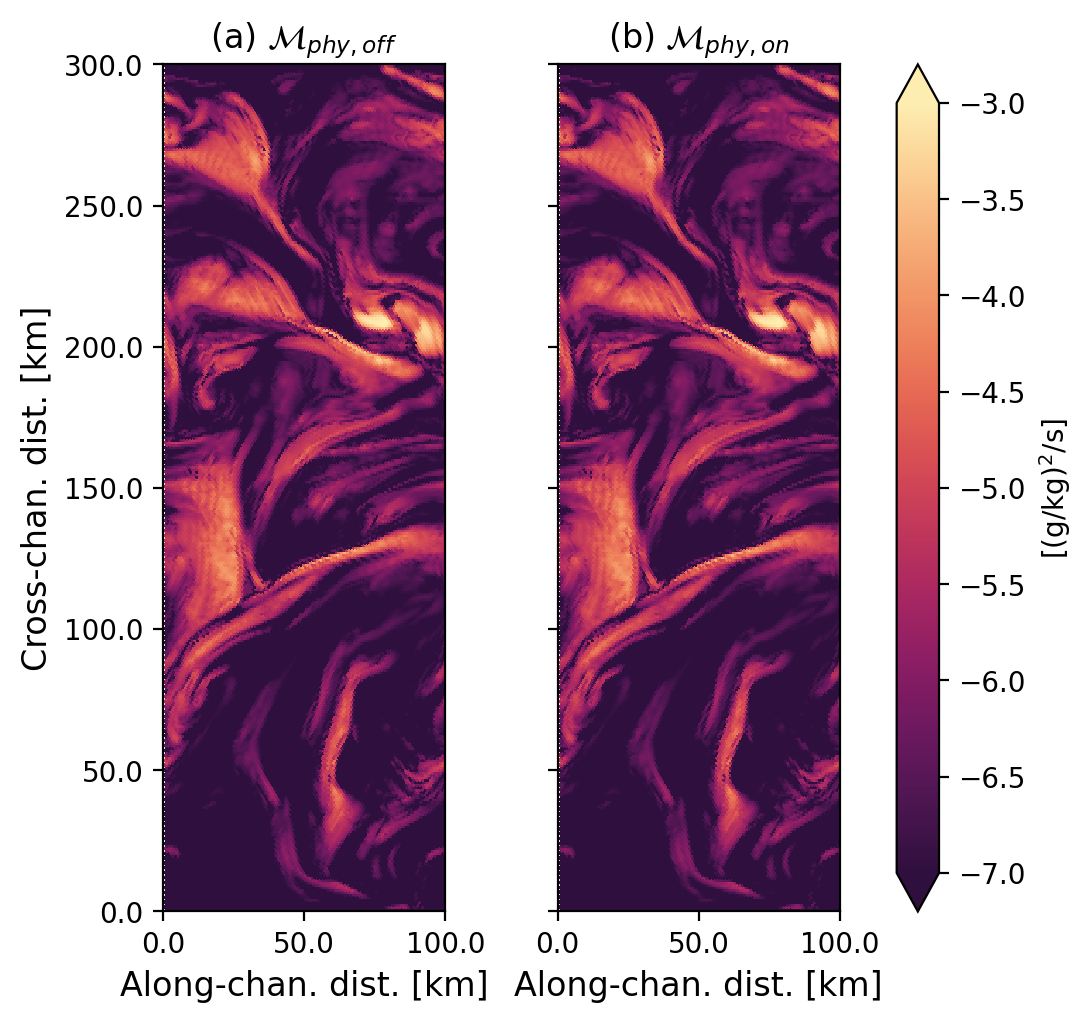

In [18]:
z = 0; t=107+12 # Day 11
fig, axes = plt.subplots(1, 2, figsize=(10/3*1.6, 5), constrained_layout=True,dpi=200)

# Panel (a): M_phy,off
data = safe_log10(dso1km.chiv_off_center.isel(nVertLevels=z, Time=t))
c = mosaic.polypcolor(axes[0], descriptor, data, 
                      vmin = -7, vmax = -3, antialiaseds=False,
                      cmap = cmo.matter_r
                     )
# Panel (b): M_phy,on
data = safe_log10(dsd1km.chiPhyVerSalt.isel(nVertLevels=z, Time=t))
c = mosaic.polypcolor(axes[1], descriptor, data, 
                      vmin = -7, vmax = -3, antialiaseds=False,
                      cmap = cmo.matter_r
                      )
fig.colorbar(c, ax=axes[1], label = r'[(g/kg)$^2$/s]', extend='both')

for ax in axes:
    ax.set_xticks(np.arange(0, 350000, 50000))
    ax.set_yticks(np.arange(0, 350000, 50000))
    ax.set_xlim(0, 100000)
    ax.set_ylim(0, 300000)
    ax.set_aspect(1.0)
    ax.set_xticklabels([str(x / 1000.0) for x in ax.get_xticks()])
    ax.set_yticklabels([str(y / 1000.0) for y in ax.get_yticks()])
    ax.set_xlabel('Along-chan. dist. [km]', fontsize=12)
    ax.set_ylabel('Cross-chan. dist. [km]', fontsize=12)

for ax in axes[1:]:
    ax.set_ylabel('')
    ax.set_yticklabels('')

axes[0].set_title(r'(a) $\mathcal{M}_{phy,off}$')
axes[1].set_title(r'(b) $\mathcal{M}_{phy,on}$')
plt.savefig('mphy_val_plan_view.png', dpi=300, bbox_inches='tight')

### Do volume integrals

In [11]:
xcell = dsg1km.xCell.values
ycell = dsg1km.yCell.values

# Remove some grid points away from the boundaries. Recall free slip walls at N-S and periodic E-W
mask = np.logical_and.reduce([
    xcell > 2000,
    xcell < 98000,
    ycell > 2000,
    ycell < 298000
])

# Get indices where condition is True
idx = np.where(mask)[0]

mphy_salt_dvon = (
    dsd1km.chiPhyVerSalt.isel(nCells=idx) *
    dso1km.layerThickness.isel(nCells=idx) *
    dsg1km.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()

mphy_salt_dvoff = (
    dso1km.chiv_off_center.isel(nCells=idx) *
    dso1km.layerThickness.isel(nCells=idx) *
    dsg1km.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()


### Create a time series of on- and offline mixing and their differences 

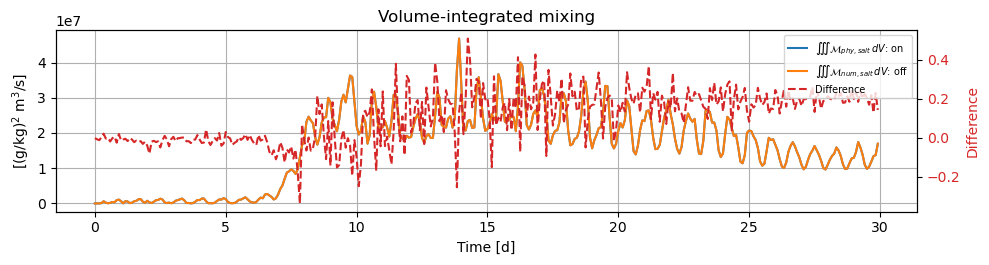

In [22]:
# --- Create figure and first axis ---
fig, ax = plt.subplots(1, figsize=(10, 2.75), dpi=100)

time = (np.arange(0, len(dsd1km.xtime)) * (2/24))  # assuming 2-hourly data

# Plot the two main lines on the primary y-axis
ax.plot(time, mphy_salt_dvon, label=r'$\iiint \mathcal{M}_{phy,salt} \, dV$: on')
ax.plot(time, mphy_salt_dvoff, label=r'$\iiint \mathcal{M}_{num,salt} \, dV$: off')

# Axis labels and formatting
ax.set_xlabel('Time [d]')
ax.set_ylabel(r'[(g/kg)$^2$ m$^3$/s]')
ax.grid(True)
ax.set_title('Volume-integrated mixing')

# --- Create secondary y-axis for the difference ---
ax2 = ax.twinx()

# Calculate and plot the difference
difference = mphy_salt_dvon - mphy_salt_dvoff
ax2.plot(time, difference, color='tab:red', linestyle='--', label='Difference')

# Axis label for the difference
ax2.set_ylabel('Difference', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Optional: Add second legend for difference
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=7)

# Optional: Limit x-axis range
# ax.set_xlim(0, 20)

plt.tight_layout()
# plt.show()
plt.savefig('mphy_val_time.png', dpi=200, bbox_inches='tight')